In [17]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime 
import numpy as np
from sklearn.metrics import mean_squared_error, explained_variance_score, r2_score
import math

from sklearn.model_selection import train_test_split

from xgboost import XGBRegressor
import xgboost as xgb

#To check for model training time
import time

pd.options.display.max_rows = None
pd.options.display.max_columns = None

from sklearn import tree

import warnings
warnings.filterwarnings("ignore", "is_categorical_dtype")
warnings.filterwarnings("ignore", "use_inf_as_na")
warnings.filterwarnings("ignore", "is_sparse")


In [2]:
df = pd.read_csv(r'F:\Kabir\CSUN\Comp542\sampled_and_preprocessed_csv_team_4.csv')

In [3]:
df.head()

,source,destination,cab_type,product_id,name,price,distance,surge_multiplier,humidity,visibility,icon,windBearing,moonPhase,precipIntensityMax
0,5,7,0,6,5,7.0,0.44,1.0,0.75,10.000,1,240,0.68,0.1064
1,5,7,0,10,6,9.0,0.44,1.0,0.70,10.000,5,303,0.72,0.0001
2,0,8,0,6,5,7.0,1.08,1.0,0.63,10.000,2,295,0.72,0.0000
3,6,11,1,0,9,7.5,1.11,1.0,0.56,9.959,4,76,0.21,0.0001
4,6,11,1,5,11,7.5,1.11,1.0,0.86,4.054,6,57,0.30,0.1252


In [4]:
list_of_columns = list(df.columns)
#print("list of cols", list_of_columns, type(list_of_columns))
list_of_columns.remove('price')
x_columns = list_of_columns
y_columns = ['price']
print('List X : ', x_columns,'\nList Y :', y_columns)

List X :  ['source', 'destination', 'cab_type', 'product_id', 'name', 'distance', 'surge_multiplier', 'humidity', 'visibility', 'icon', 'windBearing', 'moonPhase', 'precipIntensityMax'] 
List Y : ['price']


In [5]:
#Splitting DF.

x = df[x_columns]
y = df[y_columns]
print('X DF : ', x.head())
print('Y DF : ',y.head())

X DF :     source  destination  cab_type  product_id  name  distance  \
0       5            7         0           6     5      0.44   
1       5            7         0          10     6      0.44   
2       0            8         0           6     5      1.08   
3       6           11         1           0     9      1.11   
4       6           11         1           5    11      1.11   

   surge_multiplier  humidity  visibility  icon  windBearing  moonPhase  \
0               1.0      0.75      10.000     1          240       0.68   
1               1.0      0.70      10.000     5          303       0.72   
2               1.0      0.63      10.000     2          295       0.72   
3               1.0      0.56       9.959     4           76       0.21   
4               1.0      0.86       4.054     6           57       0.30   

   precipIntensityMax  
0              0.1064  
1              0.0001  
2              0.0000  
3              0.0001  
4              0.1252  
Y DF :     p

In [6]:
# Split dataset to training and test set
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 0)

In [8]:

#Code 2

#=========================================================================
# XGBoost regression: 
# Parameters: 
# n_estimators  "Number of gradient boosted trees. Equivalent to number 
#                of boosting rounds."
# learning_rate "Boosting learning rate (also known as “eta”)"
# max_depth     "Maximum depth of a tree. Increasing this value will make 
#                the model more complex and more likely to overfit." 
#=========================================================================
start_time = time.time()

regressor=xgb.XGBRegressor(eval_metric='rmsle')

#=========================================================================
# exhaustively search for the optimal hyperparameters
#=========================================================================
from sklearn.model_selection import GridSearchCV
# set up our search grid
param_grid = {"max_depth":    [4, 5, 6, 7, 3, 12],
              "n_estimators": [500, 600, 700, 800, 900, 1000],
              "learning_rate": [0.01, 0.015, 0.05, 0.1, 0.025, 0.03]}

# try out every combination of the above values
search = GridSearchCV(regressor, param_grid, cv=5).fit(X_train, y_train)

print("The best hyperparameters are ",search.best_params_)

end_time = time.time()

print("GridSearching for optimization Time (seconds) : ", round(end_time - start_time, 2))


The best hyperparameters are  {'learning_rate': 0.015, 'max_depth': 4, 'n_estimators': 1000}
GridSearching for optimization Time (seconds) :  1197.1


In [9]:

start_time = time.time()
#model.fit(X_train, y_train)


regressor=xgb.XGBRegressor(learning_rate = search.best_params_["learning_rate"],
                           n_estimators  = search.best_params_["n_estimators"],
                           max_depth     = search.best_params_["max_depth"],
                           eval_metric='rmsle', booster = 'gbtree', tree_method='exact', random_state = 123, base_score = 1, \
                           colsample_bylevel=1,colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,importance_type='gain')

regressor.fit(X_train, y_train)

end_time = time.time()

print("XG Boost Model Training Time (seconds) : ", round(end_time - start_time, 2))

C:\Users\isha\zoro_venv\Lib\site-packages\xgboost\core.py:160: UserWarning: [15:05:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0cec3277c4d9d0165-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:45: `gpu_id` is deprecated since2.0.0, use `device` instead. E.g. device=cpu/cuda/cuda:0
  warnings.warn(smsg, UserWarning)


XG Boost Model Training Time (seconds) :  0.76


<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

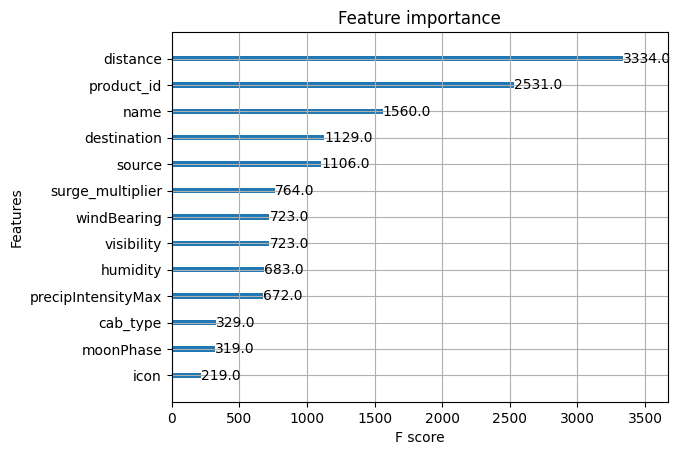

In [11]:
xgb.plot_importance(regressor, ax=plt.gca())

In [14]:
# Code 2

predictions = regressor.predict(X_test)

pred_train = regressor.predict(X_train)


print( "R2 Score Training : %0.3f" %r2_score(y_train, pred_train) ) # how much variance the regressor explains?
print( "Mean Square Error Training : %0.3f" %mean_squared_error(y_train, pred_train) )


print("Model score Testing : %0.3f" %regressor.score(X_test, y_test) ) ## R^2



print("R2 Score Testing : %0.3f" %r2_score(y_test, predictions))



print("Mean Square Error Testing : %0.3f" %mean_squared_error(y_test, predictions))

R2 Score Training : 0.976
Mean Square Error Training : 1.887
Model score Testing : 0.970
R2 Score Testing : 0.970
Mean Square Error Testing : 2.287


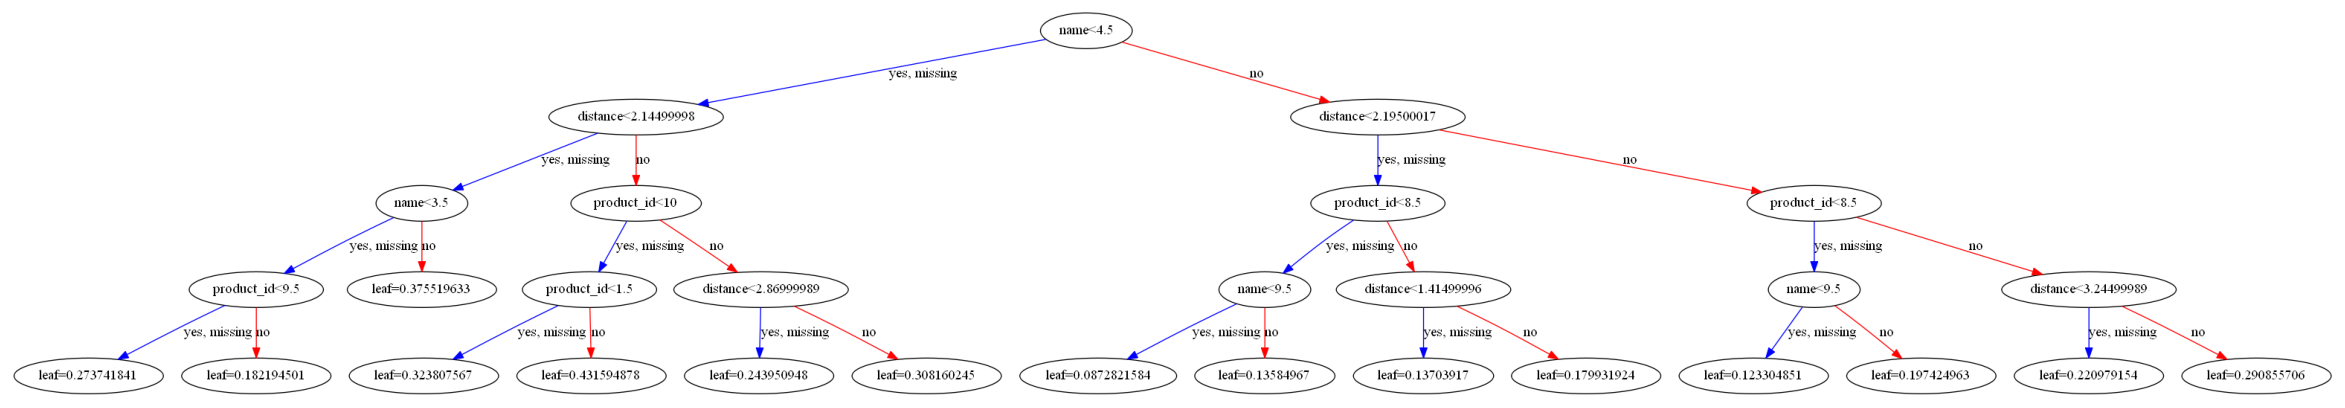

In [19]:
### Add path to Graphviz binary folder.
import os
os.environ["PATH"] += os.pathsep + r'C:\Users\isha\zoro_venv\Lib\site-packages\treeplot\RESOURCES\graphviz-2.38\release\bin'

fig, ax = plt.subplots(figsize=(30, 30))

xgb.plot_tree(regressor, num_trees=4, ax=ax)

plt.show()

In [20]:
print("EXP Variance Score Train : ", explained_variance_score(regressor.predict(X_train),y_train))
print("EXP Variance Score Test : ", explained_variance_score(regressor.predict(X_test),y_test))

EXP Variance Score Train :  0.9746265279686337
EXP Variance Score Test :  0.9687117682828873
